根据之前实验，RNN在预测具体价格的时准确率并不高，这期我们接着看下其在预测市场走势、和市场波动率上否有所提高。

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from pprint import pprint
from pylab import plt, mpl

导入沪深300指数过去5年的收盘价数据，并拆分成训练集和测试集。

In [2]:
import akshare as ak
ticker = 'sh000300'
csi300_daily = ak.stock_zh_index_daily(symbol=ticker)
split = csi300_daily.shape[0]-220*5
csi300_close = csi300_daily.close.iloc[split:]
csi300_date = csi300_daily.date.iloc[split:]

取收盘价的retrun，并通过描述统计看下两个数据集的情况。

In [123]:
csi300_chg = csi300_close/csi300_close.shift(1)-1
csi300_chg.dropna(inplace = True)
csi300_chg.shape

(1099,)

In [124]:
csi300_date = csi300_date[1:]
split = int(len(csi300_chg.values)*0.90)
csi300_train = csi300_chg.iloc[:split]
csi300_test = csi300_chg.iloc[split:]
date_train = csi300_date[:split]
date_test = csi300_date[split:]

In [125]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [126]:
statTest1=adfuller(csi300_train)[0:2]
print("The test statistic and p-value of ADF test after log return are {}"\
      .format(statTest1))

The test statistic and p-value of ADF test after log return are (-14.151892339641769, 2.1546500260215842e-26)


In [127]:
statTest2=adfuller(csi300_test)[0:2]
print("The test statistic and p-value of ADF test after log return are {}"\
      .format(statTest2))

The test statistic and p-value of ADF test after log return are (-10.535758599995056, 8.910196973024363e-19)


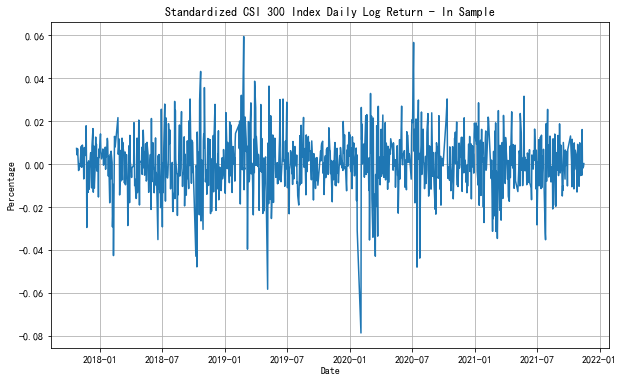

In [128]:
x = date_train
y = csi300_train
plt.figure(figsize=(10, 6))
plt.plot(x,y)
plt.title('Standardized CSI 300 Index Daily Log Return - In Sample')
plt.ylabel('Percentage')
plt.xlabel('Date')
plt.grid()

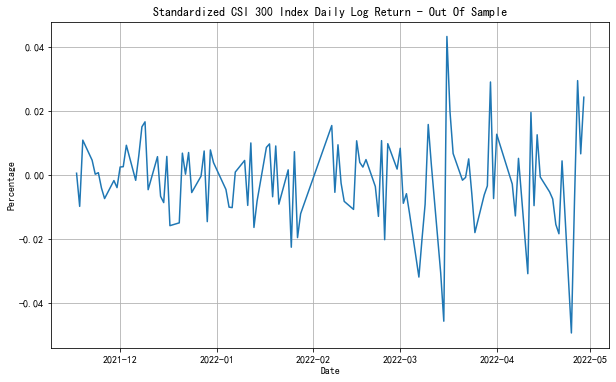

In [129]:
x = date_test
y = csi300_test
plt.figure(figsize=(10, 6))
plt.plot(x,y)
plt.title('Standardized CSI 300 Index Daily Log Return - Out Of Sample')
plt.ylabel('Percentage')
plt.xlabel('Date')
plt.grid()

In [130]:
csi300_train = pd.DataFrame(csi300_train)
csi300_train = csi300_train.values
csi300_test = pd.DataFrame(csi300_test)
csi300_test = csi300_test.values

In [135]:
csi300_train[:5]

array([[ 0.00727511],
       [ 0.00443351],
       [ 0.00418059],
       [ 0.00710967],
       [-0.00304478]])

In [136]:
csi300_test[:5]

array([[ 0.00049823],
       [-0.00985211],
       [ 0.01083984],
       [ 0.00456866],
       [ 0.00019278]])

转为三维数据组形式，训练LTSM模型。

In [60]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [61]:
lags = 5

In [137]:
g_train = TimeseriesGenerator(csi300_train, csi300_train, length=lags, batch_size=128)
g_test = TimeseriesGenerator(csi300_test, csi300_test, length=lags, batch_size=128)

In [157]:
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

In [158]:
model = Sequential()
model.add(SimpleRNN(200, activation='relu', input_shape=(lags, 1)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adagrad', loss='mse', metrics=['mae'])

In [159]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 200)               40400     
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________


In [160]:
%%time
model.fit(g_train, epochs=200, steps_per_epoch=5, verbose=False)

CPU times: total: 17.9 s
Wall time: 7.76 s


In [152]:
res = pd.DataFrame(model.history.history)
res.tail(3)

,loss,mae
197,0.000187,0.009901
198,0.000147,0.008842
199,0.000159,0.009245


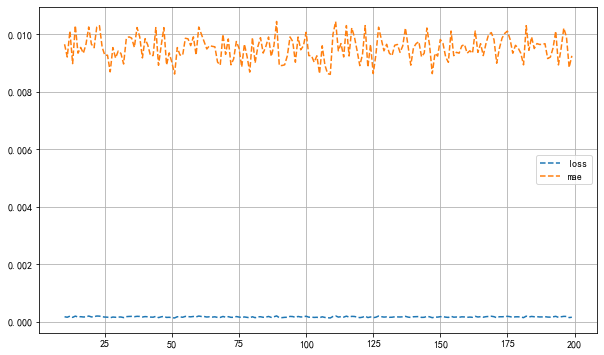

In [153]:
res.iloc[10:].plot(figsize=(10, 6), style=['--', '--']);
plt.grid()

In [154]:
y = model.predict(g_train, verbose=False)

In [155]:
y_hat = y.flatten()
x_hat = csi300_train[lags:]

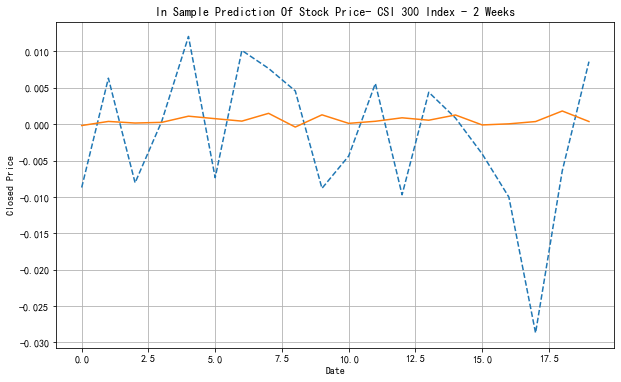

In [156]:
fig, ax=plt.subplots(figsize=(10,6))
ax.plot(x_hat[80:100], label='Actual Stock Price', linestyle='--')
ax.plot(y_hat[80:100], linestyle='solid', label="Prediction")
ax.set_title('In Sample Prediction Of Stock Price- CSI 300 Index - 2 Weeks')
ax.set(xlabel='Date', ylabel='Closed Price')
plt.grid()

就具体点位的预测看，误差就很大了，且这还是样本内的。用之前预留的csi300_test这部分干净的数据，再看看样本外的效果。

In [161]:
y = model.predict(g_test, verbose=False)
y_hat = y.flatten()
x_hat = csi300_test[lags:]

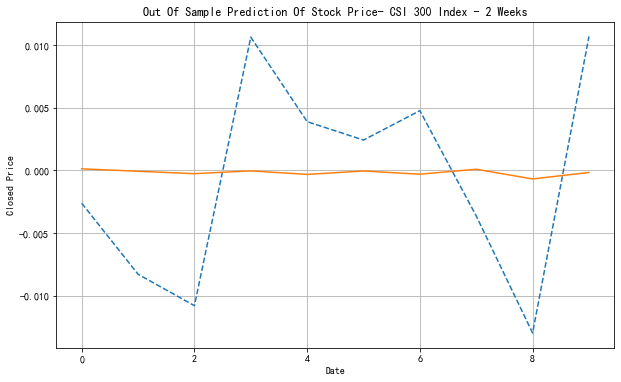

In [162]:
fig, ax=plt.subplots(figsize=(10,6))
ax.plot(x_hat[50:60], label='Actual Stock Price', linestyle='--')
ax.plot(y_hat[50:60], linestyle='solid', label="Prediction")
ax.set_title('Out Of Sample Prediction Of Stock Price- CSI 300 Index - 2 Weeks')
ax.set(xlabel='Date', ylabel='Closed Price')
plt.grid()